# This notebook is for making color coded phase maps, similar to ones produced by Joao's wfield application and also the contour lines

In [1]:
import cv2
import tifffile as tf
from wfield_utils import *
from matplotlib import colors
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 1. Reading the avg movies

The cell below reads the avg movie files, the ones created by Ben's trial averaging code have the shape (T x H x W), where T is the dimension of the frames.

Tip: if you put an _r_ before your string, you can just copy the path of your movie without having to replace slashes with double-slashes.

In [29]:
path_to_avg_mov = r"J:\analysis\221215_LV002__1P_VO\run00_151558_02_checkerboard_lowSF_calcium\movies\avg_01.tif"

avg_movie = tf.imread(path_to_avg_mov) # read movie
avg_movie = avg_movie[:,:,::-1] # flip the width dimension, so the lateral direction is on the left side when viewing
# avg_movie = cv2.normalize(avg_movie, None, 0, 2**16, cv2.NORM_MINMAX, cv2.CV_16U) # map the values to-16 bit
    
print(f'Shape of the avg movie is {avg_movie.shape}')

Shape of the avg movie is (440, 501, 502)


This process assumes that there are no frames corresponding to pre- or post-blank periods. If that is not the case, you can index the 0th dimension accordingly to get rid of those frames.

For example, if you know that the first 10 frames correspond to pre-blank period, you can do:

```avg_movie = avg_movie[10:,:,:]```

## 2. View the avg movie

{'fig': <Figure size 432x288 with 1 Axes>,
 'ax': <AxesSubplot:>,
 'im': <matplotlib.image.AxesImage at 0x269ec8e3670>,
 'update': <function wfield_utils.nb_play_movie.<locals>.updateImage(change)>}

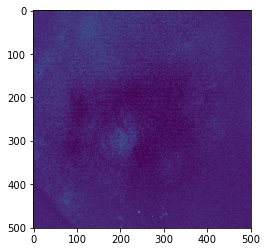

In [3]:
nb_play_movie(avg_movie) # playing the movie doesnt always work...

## 3. Frequency Analysis (optional)

This part is optional, and is here more for clarity, you can skip to 4th step if you don't want to see what the frequency analysis does. 

The cells below select a small arbitrary region that should correspond to where the stimulus related activity is and averages it in the height and width dimension. Then we take the FFT of the resulting 1-D array and plot both the averaged signal and FFT power spectrum

In [4]:
# define mask x,y,w,h
# these values probably differ for rig1 and rig2, due to different image sizes. Rig1 is (501 x 502) and rig2 is (768 x 1024)
mask_x = 100
mask_y = 300
mask_w = 100
mask_h = 100
mask_vertices = [[mask_x,mask_y],[mask_x+mask_w,mask_y],[mask_x+mask_w,mask_y+mask_h],[mask_x,mask_y+mask_h]]
arr = np.array([mask_vertices],'int')


mask = cv2.fillPoly(np.zeros(avg_movie[0,:,:].shape,np.uint8),arr,[1,1,1])
height_p,width_p = np.nonzero(mask)

In [5]:
# avg the roi
roi = avg_movie[:,height_p,width_p]
avg_roi = np.mean(roi,axis=1)

Below we do the actual FFT. here fs(sampling frequency is important. It should be $1/frame time$, which should be the close to the exposure time you've set in the labcams software.

First cell below reads the camlog data and calculates the average frame time from all the recorded frames. The second cell calculates the FFT.

**WARNING: camlog files doesn't always have the timestamps recorded, in that case you have to manually enter the fs**

In [6]:
# read the camlog
camlog_path = r"J:\1photon\raw\221129_MG016__1P_AA\run00_131844_02_checkerboard_lowSF_calcium\20221129_run001.camlog"
camlog_data,_,_ = parseCamLog(camlog_path)
avg_ftime = np.mean(np.diff(camlog_data.timestamp))

avg_ftime /= 10_000 #rig2 measures in 10's of us, so divide by 10.000 to get seconds
print(f'Avg. frame time is : {avg_ftime} seconds')

Avg. frame time is : 0.04533065046728972 seconds


In [7]:
# do FFT
fs = 1/avg_ftime

ps =  20*np.log10(np.abs(np.fft.rfft(avg_roi,axis=0)))
f = np.linspace(0, fs/2, len(ps))

Below we plot everything, be sure to change the `trial_dur` variable so that you have correct frequency marked as the red vertical line

Text(0.5, 1.0, 'Freq. Spectrum \n f_trial = 0.1 and f[1]=0.1012')

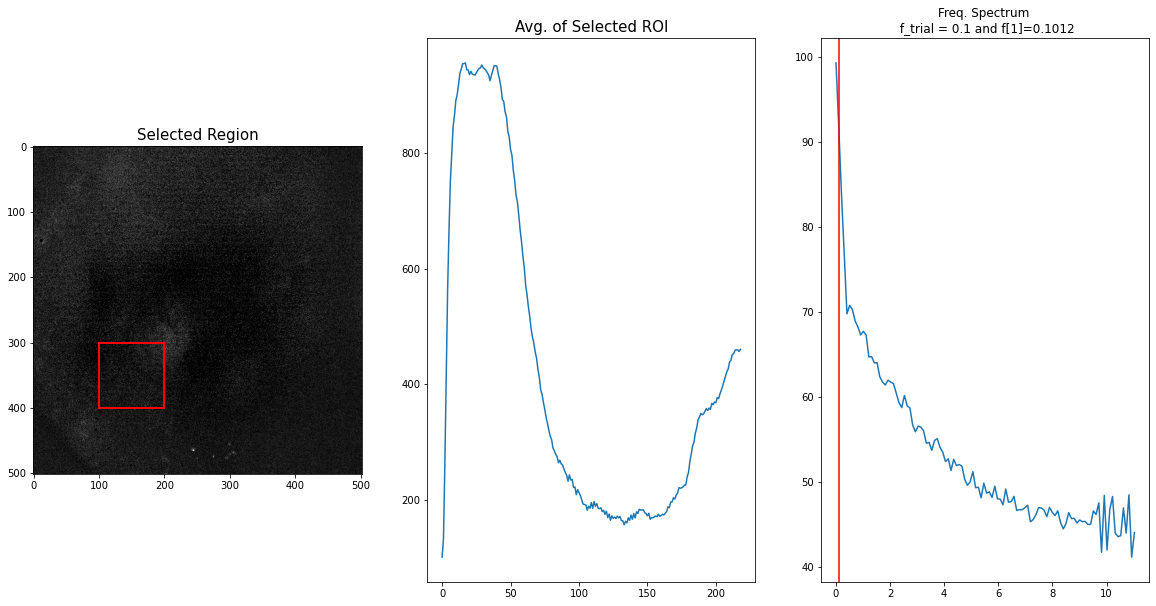

In [10]:
fig = plt.figure(figsize=(20,10))

# plotting selected region
ax = fig.add_subplot(131)
ax.imshow(avg_movie[0,:,:],cmap='gray')
ax.add_patch(Rectangle([mask_x,mask_y],mask_w,mask_h,fill=False,edgecolor='r',linewidth=2))
ax.set_title('Selected Region',fontsize=15)

# plotting avg of roi
ax_avg = fig.add_subplot(132)
ax_avg.plot(avg_roi)
ax_avg.set_title('Avg. of Selected ROI',fontsize=15)

# plotting frequency power spectrum
trial_dur = 10

ax_freq = fig.add_subplot(133)
ax_freq.plot(f,ps)
ax_freq.axvline(1/trial_dur,c='r')
ax_freq.set_title(f'Freq. Spectrum \n f_trial = {1/trial_dur} and f[1]={f[1]:.4f}')


## 4.Get the phase values in the trial frequency

We take the FFT here and select the first component, assuming the biggest frequency component in a trial averaged movie will be the trial frequency itself. This assumption holds true most of the time.

In [30]:
component = 1
movief = fft(avg_movie, axis = 0)

In [31]:
phase  = np.angle(movief[component]) % (2*np.pi)
mag = np.abs(movief[component])

Text(0.5, 1.0, 'Magnitute')

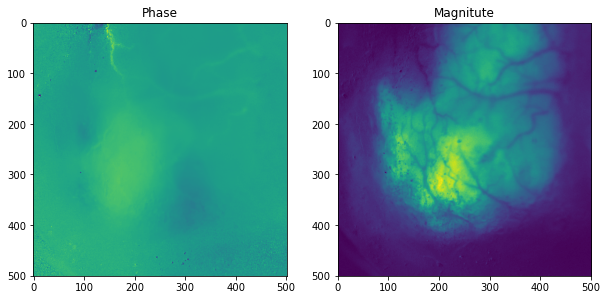

In [32]:
# plotting phase and mag for selected frequency component
fig = plt.figure(figsize=(10,10))
# stim mag,phase
ax_ps = fig.add_subplot(121)
ax_ps.imshow(phase)
ax_ps.set_title(f'Phase')

ax_ms = fig.add_subplot(122)
ax_ms.imshow(mag)
ax_ms.set_title(f'Magnitute')

## 5.1. Create the color coded phase map

__IMPORTANT: Don't forget to change the relevant `startdeg` and `stopdeg` for different stimuli__

In [33]:
startdeg = 0
stopdeg = 140
hsv_color = phasemag_to_hsv(phase,mag,startdeg,stopdeg,vperc=99) # you can increase the saturation by decreasing the vperc value
cbarim = hsv_colorbar()

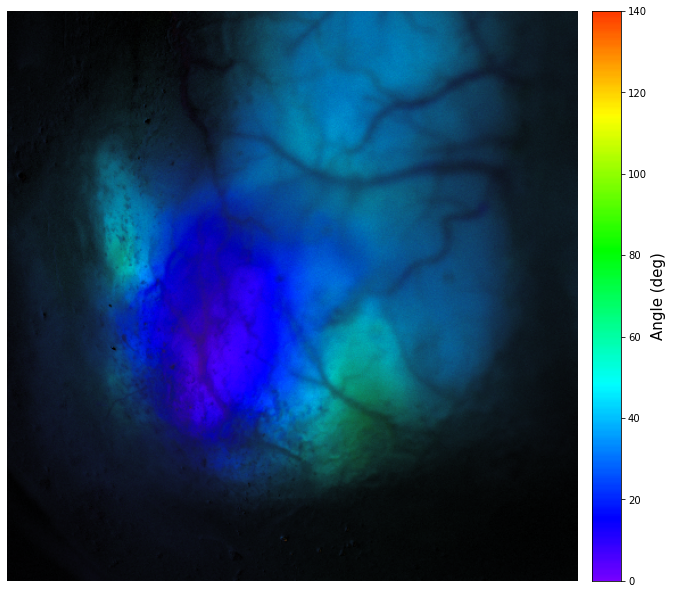

In [34]:
# Plotting
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)

ax.imshow(hsv_color)
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

cax.imshow(cbarim,aspect= 'auto',extent = [0,1,startdeg,stopdeg])
cax.yaxis.set_ticks_position('right')
cax.xaxis.set_visible(False)
cax.set_ylabel('Angle (deg)',fontsize=15)
cax.yaxis.set_label_position('right')

### Save the figure in the figures folder in this directory, don't forget to change the `save_name`.

In [35]:
save_name = '221215_LV002__1P_VO_azimuth'
fig.savefig(f'figures/{save_name}_colored_phase_map.pdf')

## 5.2. Create the color coded phase contours

In [36]:
# normalize the phase
phase /= 2*np.pi

Depending on the resolution of your image, sometimes the contour lines will appear "too detailed", in that case you cxan run the cell below to Gaussian filter and blur the image a bit. Use the sigma argument to control the amount of blurring.

In [37]:
phase = im_gaussian(phase,sigma=7)

Mask some regions of the phase map with the magnitude map. The filtering value could be different for different experiments, change the `mask_threshold` variable accordingly.

In [38]:
mask_threshold = 5000
filt_idx = np.where(mag<mask_threshold)
phase_filtered = phase[:]
phase_filtered[filt_idx] = np.nan

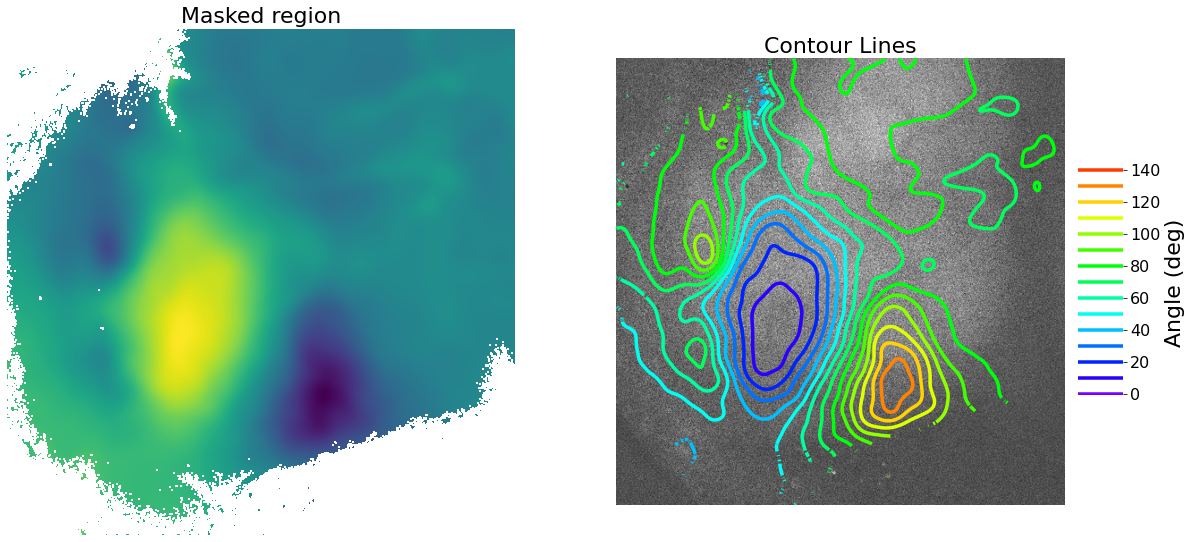

In [39]:
fig=plt.figure(figsize=(20,10))
fontsize = 22

ax_filt = fig.add_subplot(121)
ax_filt.imshow(phase_filtered)
ax_filt.set_title('Masked region',fontsize=fontsize)
ax_filt.axis('off')

ax =fig.add_subplot(122)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.2, aspect=5)

# coordinates for contours
xl = np.arange(0,phase.shape[1])
yl = np.arange(0,phase.shape[0])
X, Y = np.meshgrid(xl, yl)
degs = phasemap_to_visual_degrees(1-phase_filtered,startdeg,stopdeg)
Z = degs


step = 10
if startdeg<stopdeg:
    levels = np.arange(startdeg,stopdeg+step,step)
else:
    levels = np.arange(stopdeg,startdeg+step,step)
    levels = levels[::-1]

my_cmap = colors.ListedColormap(cbarim[::-1]/255.) # make color map
cp = ax.contour(X,Y,Z,levels=levels,linewidths=3.5,cmap=my_cmap) # add color

fig.colorbar(cp,cax) # Add a colorbar to a plot

# make it pretty
ax.axis('off')
ax.set_title('Contour Lines',fontsize=fontsize)
cax.set_ylabel(f'Angle (deg)',fontsize=fontsize)
cax.set_yticklabels(levels,fontsize=fontsize-6)
cax.yaxis.set_label_position('right')
cax.yaxis.set_ticks_position('right')

cax.xaxis.set_visible(False)
for k in cax.spines.keys():
    cax.spines[k].set_visible(False)
    
# put the ref img behind, use the first frame of avg_movie
ax.imshow(avg_movie[0,:,:],cmap='gray',alpha=0.8) 

### Save the figure in the figures folder in this directory, don't forget to change the `save_name`.

In [40]:
save_name = '221215_LV002__1P_VO'
fig.savefig(f'figures/{save_name}_colored_degree_contours.pdf')